In [1]:
import awkward as ak
import numpy as np
import time
import coffea
import uproot
import hist
import vector
print("awkward version ", ak.__version__)
print("coffea version ", coffea.__version__)
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from collections import defaultdict
import pickle
from distributed.diagnostics.plugin import UploadDirectory
import os
from plot_utils import adjust_plot
import matplotlib.pyplot as plt
from utils import Histfit
import correctionlib

from distributed.diagnostics.plugin import UploadDirectory



awkward version  1.10.3
coffea version  0.7.21
awkward version  1.10.3
coffea version  0.7.21


In [2]:
from qcd_processor_lib import QCDProcessor
from qcd_processor_runner import runner
from processor_utils import *

In [3]:
%load_ext autoreload

%autoreload 2

In [4]:
from dask.distributed import Client

client = Client("tls://aritra-2emandal-40cern-2ech.dask.cmsaf-prod.flatiron.hollandhpc.org:8786")
#client = None

/opt/conda/lib/python3.8/site-packages/distributed/client.py:1288: VersionMismatchWarning: Mismatched versions found

+---------+----------------+----------------+----------------+
| Package | client         | scheduler      | workers        |
+---------+----------------+----------------+----------------+
| python  | 3.8.16.final.0 | 3.8.16.final.0 | 3.8.15.final.0 |
+---------+----------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [5]:
import mplhep as hep
hep.style.use("CMS")
plt.rcParams['figure.dpi'] = 60

In [6]:
# Set era here
#year = 2017
eras = ["2017"]
testing = False

In [7]:
hists = runner(testing = testing, eras = eras, prependstr = 'root://xcache/', nworkers = 1, client = None  )

Output()

Output()

/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/
2017
/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/
2017
/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/
2017
/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/
2017
/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/
2017
/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/
2017
/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/
2017
/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/
2017
/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/
2017
/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/
2017
/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOA


KeyboardInterrupt



/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/
2017
/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/
2017
/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/
2017


In [ ]:
if testing == True:
    fname_out = 'test_QCD_pt_response_'+era+'JME'+'.pkl'
else:
    fname_out = 'QCD_pt_response_'+era+'JME'+'.pkl'

with open(fname_out, "wb") as f:
        pickle.dump( hists, f )
        
print(f"The histograms are stored in {fname_out}")

In [ ]:
hists["pt_reco_over_gen"].project("frac").plot(density= True)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f0a40a448b0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

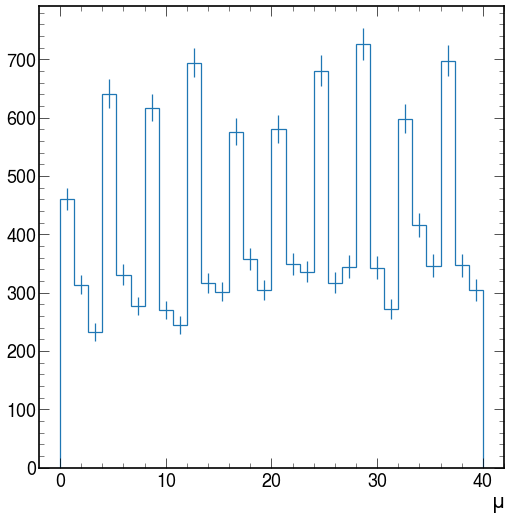

In [38]:
hists["pileup_rho"].project("pileup_fine").plot()

In [10]:
GetPUSF('2017', np.array(30))

array(1.00782377)